In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import math

In [ ]:
train_loaders = []
test_loaders = []

In [ ]:
for i in range(3):
  rng_permute = np.random.RandomState(92916+i)
  idx_permute = torch.from_numpy(rng_permute.permutation(784))
  transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                torchvision.transforms.Lambda(lambda x: x.view(-1)[idx_permute].view(1, 28, 28) )])
  train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('data', train=True, download=True,
                    transform=transform),batch_size=32, shuffle=True)
  test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('data', train=False, download=True,
                    transform=transform),batch_size=32, shuffle=True)
  train_loaders.append(train_loader)
  test_loaders.append(test_loader)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## Model

In [ ]:
class PowerPropLinear(nn. Module):
  def __init__(self, in_size, out_size, alpha):
    super().__init__()
    self.in_size = in_size
    self.out_size = out_size
    bias = torch.Tensor(out_size)
    self.bias = nn.Parameter(bias)
    self.alpha = alpha

    super_weights = torch.Tensor(out_size, in_size)
    nn.init.kaiming_uniform_(super_weights, a=math.sqrt(5))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(super_weights)
    bound = 1 / math.sqrt(fan_in)
    nn.init.uniform_(self.bias, -bound, bound) 

    abs = torch.abs(super_weights)
    signs = torch.sign(super_weights)
    weights = torch.mul(signs, torch.pow(abs, 1/alpha))
    self.weights = nn.Parameter(weights)

    self.forward_mask = torch.ones(self.weights.size())

  def forward(self, x):
    super_weights = torch.mul(torch.sign(self.weights), torch.pow(torch.abs(self.weights), self.alpha))
    w_times_x = torch.mm(x, torch.mul(super_weights, self.forward_mask).t())
    return torch.add(w_times_x, self.bias)

  def set_forward_mask(self, mask):
    self.forward_mask = mask

  def reset_forward_mask(self):
    self.forward_mask = torch.ones(self.weights.size())

### Baseline: No powerpropogation

In [ ]:
alpha = 1

In [ ]:
model2 = nn.Sequential(
    PowerPropLinear(784, 128, alpha),
    nn.ReLU(),
    PowerPropLinear(128, 10, alpha)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters())

In [ ]:
batch_size = 32
n_epochs = 10

train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

mask_backward_0 = torch.ones(model2[0].weights.size())
mask_backward_1 = torch.ones(model2[2].weights.size())

In [ ]:
S = 0.2

In [ ]:
forward_masks_0 = [torch.zeros(model2[0].weights.size()).flatten()]*len(train_loaders)
forward_masks_1 = [torch.zeros(model2[2].weights.size()).flatten()]*len(train_loaders)

In [ ]:
# training

for train_idx in range(len(train_loaders)):
  print("-----------------------------------")
  print("Task:", train_idx)
  train_loader = train_loaders[train_idx]
  train_losses = np.zeros(n_epochs)
  for it in range(n_epochs):
    train_loss = []
    for inputs, targets in train_loader:
      inputs = inputs.view(-1, 784)
      optimizer.zero_grad()
      # model2[0].reset_forward_mask()
      # model2[2].reset_forward_mask()
      outputs = model2(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      model2[0].weights.grad = model2[0].weights.grad * mask_backward_0
      model2[2].weights.grad = model2[2].weights.grad * mask_backward_1
      optimizer.step()
      train_loss.append(loss.item())
    train_loss = np.mean(train_loss) 

    train_losses[it] = train_loss

      
    print(f'Epoch {it+1}/{n_epochs}, Train Loss: {train_loss:.4f}')


  # Accuracy
  n_correct = 0
  n_total = 0

  for inputs, targets in train_loader:
    inputs = inputs.view(-1, 784)
    outputs = model2(inputs)
    _, predictions = torch.max(outputs,1)
    n_correct += (predictions==targets).sum().item()
    n_total += targets.shape[0]
  train_acc = n_correct/n_total

  print("Acc:", train_acc)

  idx_0 = torch.topk((torch.abs(model2[0].weights)*mask_backward_0).flatten(), math.floor(S*int(model2[0].weights.flatten().shape[0]))).indices
  idx_1 = torch.topk((torch.abs(model2[2].weights)*mask_backward_1).flatten(), math.floor(S*int(model2[2].weights.flatten().shape[0]))).indices
  np_mask_0 = np.zeros(model2[0].weights.flatten().size())
  np_mask_0[idx_0] = 1
  forward_masks_0[train_idx] = torch.from_numpy(np_mask_0)
  np_mask_1 = np.zeros(model2[2].weights.flatten().size())
  np_mask_1[idx_1] = 1
  forward_masks_1[train_idx] = torch.from_numpy(np_mask_1)
  # print(forward_masks_0[train_idx] == forward_masks_0[train_idx-1])

  or_mask_0 = forward_masks_0[-1]
  or_mask_1 = forward_masks_1[-1]

  for mask in forward_masks_0[:-1]:
    or_mask_0 = torch.logical_or(or_mask_0, mask).int()

  for mask in forward_masks_1[:-1]:
    or_mask_1 = torch.logical_or(or_mask_1, mask).int()

  mask_backward_0 = torch.logical_not(or_mask_0.reshape(model2[0].weights.size())).int()
  mask_backward_1 = torch.logical_not(or_mask_1.reshape(model2[2].weights.size())).int()

  # print("masks")
  # print(torch.sum(mask_backward_0))
  # print(torch.sum(mask_backward_1))


-----------------------------------
Task: 0
Epoch 1/10, Train Loss: 0.2925
Epoch 2/10, Train Loss: 0.1280
Epoch 3/10, Train Loss: 0.0866
Epoch 4/10, Train Loss: 0.0648
Epoch 5/10, Train Loss: 0.0501
Epoch 6/10, Train Loss: 0.0382
Epoch 7/10, Train Loss: 0.0303
Epoch 8/10, Train Loss: 0.0249
Epoch 9/10, Train Loss: 0.0202
Epoch 10/10, Train Loss: 0.0170
Acc: 0.9967666666666667
-----------------------------------
Task: 1
Epoch 1/10, Train Loss: 0.0108
Epoch 2/10, Train Loss: 0.0099
Epoch 3/10, Train Loss: 0.0090
Epoch 4/10, Train Loss: 0.0081
Epoch 5/10, Train Loss: 0.0069
Epoch 6/10, Train Loss: 0.0068
Epoch 7/10, Train Loss: 0.0071
Epoch 8/10, Train Loss: 0.0060
Epoch 9/10, Train Loss: 0.0047
Epoch 10/10, Train Loss: 0.0059
Acc: 0.9983833333333333
-----------------------------------
Task: 2
Epoch 1/10, Train Loss: 0.0026
Epoch 2/10, Train Loss: 0.0028
Epoch 3/10, Train Loss: 0.0025
Epoch 4/10, Train Loss: 0.0029
Epoch 5/10, Train Loss: 0.0023
Epoch 6/10, Train Loss: 0.0019
Epoch 7/10, 

In [ ]:
weights = np.concatenate((model2[0].weights.cpu().detach().numpy().flatten(), model2[2].weights.cpu().detach().numpy().flatten()))

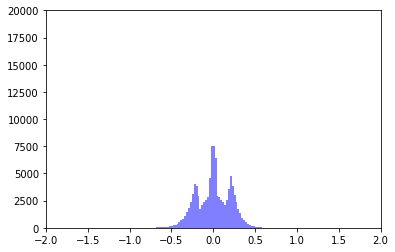

In [ ]:
plt.hist(weights, bins=100, alpha=0.5, color = "blue")
plt.xlim([-2, 2])
plt.ylim([0, 20000])
plt.show()

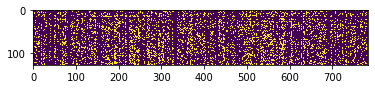

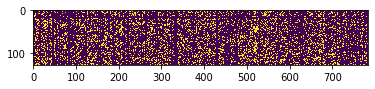

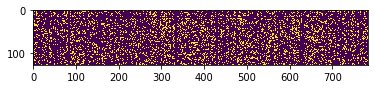

In [ ]:
for mask in forward_masks_0:
  plt.imshow(mask.reshape(model2[0].weights.size()).numpy(), interpolation='nearest')
  plt.show()

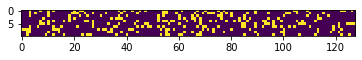

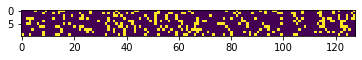

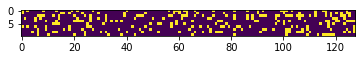

In [ ]:
for mask in forward_masks_1:
  plt.imshow(mask.reshape(model2[2].weights.size()).numpy(), interpolation='nearest')
  plt.show()

In [ ]:
for train_idx in range(len(train_loaders)):
  train_loader = train_loaders[train_idx]
  for inputs, targets in train_loader:
      inputs = inputs.view(-1, 784)
      model2[0].reset_forward_mask()
      model2[0].set_forward_mask(forward_masks_0[train_idx].reshape(model2[0].weights.size()).float())
      model2[2].reset_forward_mask()
      model2[2].set_forward_mask(forward_masks_1[train_idx].reshape(model2[2].weights.size()).float())
      outputs = model2(inputs)
      _, predictions = torch.max(outputs,1)
      n_correct += (predictions==targets).sum().item()
      n_total += targets.shape[0]
      train_acc = n_correct/n_total
  print("Task:", train_idx)
  print("Acc:", train_acc)

Task: 0
Acc: 0.9083916666666667
Task: 1
Acc: 0.6848444444444445
Task: 2
Acc: 0.5510083333333333


### EfficientPackNet: with PowerPropogation

In [ ]:
alpha = 1.5

In [ ]:
model2 = nn.Sequential(
    PowerPropLinear(784, 128, alpha),
    nn.ReLU(),
    PowerPropLinear(128, 10, alpha)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters())

In [ ]:
batch_size = 32
n_epochs = 10

train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

mask_backward_0 = torch.ones(model2[0].weights.size())
mask_backward_1 = torch.ones(model2[2].weights.size())

In [ ]:
S = 0.2

In [ ]:
forward_masks_0 = [torch.zeros(model2[0].weights.size()).flatten()]*len(train_loaders)
forward_masks_1 = [torch.zeros(model2[2].weights.size()).flatten()]*len(train_loaders)

In [ ]:
# training

for train_idx in range(len(train_loaders)):
  print("-----------------------------------")
  print("Task:", train_idx)
  train_loader = train_loaders[train_idx]
  train_losses = np.zeros(n_epochs)
  for it in range(n_epochs):
    train_loss = []
    for inputs, targets in train_loader:
      inputs = inputs.view(-1, 784)
      optimizer.zero_grad()
      # model2[0].reset_forward_mask()
      # model2[2].reset_forward_mask()
      outputs = model2(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      model2[0].weights.grad = model2[0].weights.grad * mask_backward_0
      model2[2].weights.grad = model2[2].weights.grad * mask_backward_1
      optimizer.step()
      train_loss.append(loss.item())
    train_loss = np.mean(train_loss) 

    train_losses[it] = train_loss

      
    print(f'Epoch {it+1}/{n_epochs}, Train Loss: {train_loss:.4f}')


  # Accuracy
  n_correct = 0
  n_total = 0

  for inputs, targets in train_loader:
    inputs = inputs.view(-1, 784)
    outputs = model2(inputs)
    _, predictions = torch.max(outputs,1)
    n_correct += (predictions==targets).sum().item()
    n_total += targets.shape[0]
  train_acc = n_correct/n_total

  print("Acc:", train_acc)

  idx_0 = torch.topk((torch.abs(model2[0].weights)*mask_backward_0).flatten(), math.floor(S*int(model2[0].weights.flatten().shape[0]))).indices
  idx_1 = torch.topk((torch.abs(model2[2].weights)*mask_backward_1).flatten(), math.floor(S*int(model2[2].weights.flatten().shape[0]))).indices
  np_mask_0 = np.zeros(model2[0].weights.flatten().size())
  np_mask_0[idx_0] = 1
  forward_masks_0[train_idx] = torch.from_numpy(np_mask_0)
  np_mask_1 = np.zeros(model2[2].weights.flatten().size())
  np_mask_1[idx_1] = 1
  forward_masks_1[train_idx] = torch.from_numpy(np_mask_1)
  # print(forward_masks_0[train_idx] == forward_masks_0[train_idx-1])

  or_mask_0 = forward_masks_0[-1]
  or_mask_1 = forward_masks_1[-1]

  for mask in forward_masks_0[:-1]:
    or_mask_0 = torch.logical_or(or_mask_0, mask).int()

  for mask in forward_masks_1[:-1]:
    or_mask_1 = torch.logical_or(or_mask_1, mask).int()

  mask_backward_0 = torch.logical_not(or_mask_0.reshape(model2[0].weights.size())).int()
  mask_backward_1 = torch.logical_not(or_mask_1.reshape(model2[2].weights.size())).int()

  # print("masks")
  # print(torch.sum(mask_backward_0))
  # print(torch.sum(mask_backward_1))


-----------------------------------
Task: 0
Epoch 1/10, Train Loss: 0.3681
Epoch 2/10, Train Loss: 0.1592
Epoch 3/10, Train Loss: 0.1086
Epoch 4/10, Train Loss: 0.0808
Epoch 5/10, Train Loss: 0.0639
Epoch 6/10, Train Loss: 0.0516
Epoch 7/10, Train Loss: 0.0418
Epoch 8/10, Train Loss: 0.0343
Epoch 9/10, Train Loss: 0.0284
Epoch 10/10, Train Loss: 0.0230
Acc: 0.9955
-----------------------------------
Task: 1
Epoch 1/10, Train Loss: 0.0158
Epoch 2/10, Train Loss: 0.0138
Epoch 3/10, Train Loss: 0.0125
Epoch 4/10, Train Loss: 0.0113
Epoch 5/10, Train Loss: 0.0096
Epoch 6/10, Train Loss: 0.0090
Epoch 7/10, Train Loss: 0.0081
Epoch 8/10, Train Loss: 0.0071
Epoch 9/10, Train Loss: 0.0069
Epoch 10/10, Train Loss: 0.0057
Acc: 0.9998833333333333
-----------------------------------
Task: 2
Epoch 1/10, Train Loss: 0.0040
Epoch 2/10, Train Loss: 0.0039
Epoch 3/10, Train Loss: 0.0036
Epoch 4/10, Train Loss: 0.0036
Epoch 5/10, Train Loss: 0.0033
Epoch 6/10, Train Loss: 0.0033
Epoch 7/10, Train Loss: 

In [ ]:
weights = np.concatenate((model2[0].weights.cpu().detach().numpy().flatten(), model2[2].weights.cpu().detach().numpy().flatten()))

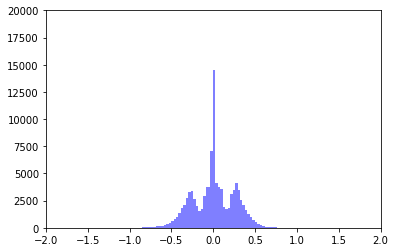

In [ ]:
plt.hist(weights, bins=100, alpha=0.5, color = "blue")
plt.xlim([-2, 2])
plt.ylim([0, 20000])
plt.show()

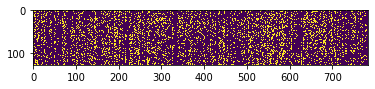

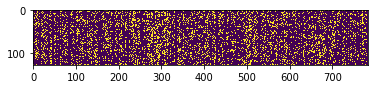

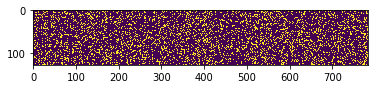

In [ ]:
for mask in forward_masks_0:
  plt.imshow(mask.reshape(model2[0].weights.size()).numpy(), interpolation='nearest')
  plt.show()

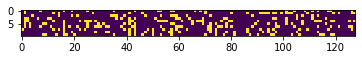

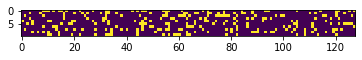

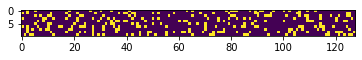

In [ ]:
for mask in forward_masks_1:
  plt.imshow(mask.reshape(model2[2].weights.size()).numpy(), interpolation='nearest')
  plt.show()

In [ ]:
for train_idx in range(len(train_loaders)):
  train_loader = train_loaders[train_idx]
  for inputs, targets in train_loader:
      inputs = inputs.view(-1, 784)
      model2[0].reset_forward_mask()
      model2[0].set_forward_mask(forward_masks_0[train_idx].reshape(model2[0].weights.size()).float())
      model2[2].reset_forward_mask()
      model2[2].set_forward_mask(forward_masks_1[train_idx].reshape(model2[2].weights.size()).float())
      outputs = model2(inputs)
      _, predictions = torch.max(outputs,1)
      n_correct += (predictions==targets).sum().item()
      n_total += targets.shape[0]
      train_acc = n_correct/n_total
  print("Task:", train_idx)
  print("Acc:", train_acc)

Task: 0
Acc: 0.919875
Task: 1
Acc: 0.7259888888888889
Task: 2
Acc: 0.5784708333333334
